In [1]:
import torch as t
from torch.utils import data
from torchvision import transforms as T
from torchvision import models
import torch.nn as nn
from PIL import Image
import numpy as np
from scipy.misc import imresize,imread
device = t.device('cuda' if t.cuda.is_available() else 'cpu')

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class salnet(nn.Module):
    def __init__(self):
        super(salnet,self).__init__()
        
        vgg16 = models.vgg16(pretrained=True)
        
        encoder = list(vgg16.features.children())[:-1]
        self.encoder = nn.Sequential(*encoder)
        self.decoder = nn.Conv2d(512,1,1,padding=0,bias=False)
    def forward(self,x):
        e_x = self.encoder(x)
        d_x = self.decoder(e_x)
        d_x = nn.functional.interpolate(d_x,size=(480,640),mode='bilinear',align_corners=False)
        d_x = d_x.squeeze(1)
        mi = t.min(d_x.view(-1,480*640),1)[0].view(-1,1,1)
        ma = t.max(d_x.view(-1,480*640),1)[0].view(-1,1,1)
        n_x = (d_x-mi)/(ma-mi)
        return e_x,n_x

In [4]:
transform = T.Compose([
        #T.Resize(224),
        #T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [5]:
model = salnet()
model.load_state_dict(t.load('./model/4000.pt',map_location='cpu'))
#model = model.to(device)
model.eval()

salnet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv

In [6]:
im = Image.open('./exa_data/1023.jpg')
s = im.size
t_im = im.resize((224,224))
t_im = transform(t_im).unsqueeze(0)

In [7]:
act_map,sal_map = model(t_im) ###act_map is the activationmap in conv5_3 layer

In [8]:
sal_map = sal_map.squeeze(0)
act_map = act_map.squeeze(0)
sal_map = sal_map.detach().numpy()
act_map = act_map.detach().numpy()

In [9]:
sal_map = imresize(sal_map,[s[1],s[0]])

/Users/apple/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


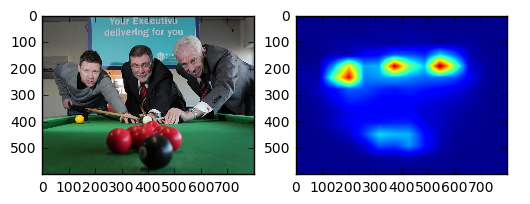

In [10]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(im)
axarr[1].imshow(sal_map)

In [11]:
ma = np.load('53_act_ma.npy')
mi = np.load('53_act_mi.npy')

In [12]:
####normalize activation map
n_act_map = np.zeros((512,14,14))
for i in range(512):
    temp = act_map[i,:,:]
    if len(np.unique(temp[:]))==1:
        n_act_map[i,:,:] = temp
    else:
        temp = (temp-mi[i])/(ma[i]-mi[i])
        n_act_map[i,:,:] = temp

/Users/apple/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/Users/apple/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


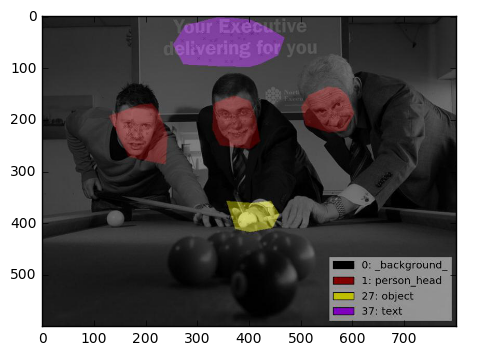

In [13]:
####show annotation###
seg_anno = imread('./exa_data/seg_label.jpg')
instance_anno = imread('./exa_data/instance_label.jpg')
plt.imshow(seg_anno)

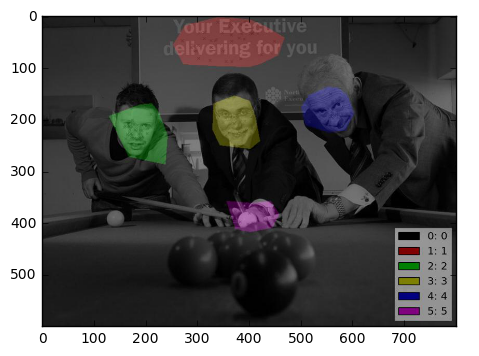

In [14]:
plt.imshow(instance_anno)

In [15]:
def nss(sal,fix):
    sal = imresize(sal,fix.shape)/255.0
    m = np.mean(sal[:])
    v = np.std(sal[:])
    if m != 0:
        sal = (sal-m)/v
    score = np.mean(sal[np.nonzero(fix)])
    return score

In [16]:
###compute the association of the activation map and each annotated salient regions (region based NSS score)##
fix = imread('./exa_data/1023.png')/255.0
ima = np.load('./exa_data/1023.npy')
N = len(np.unique(ima[:]))
print(N)
sta = []
for j in range(N-1):
    temp = (ima==j+1)
    t_fix = fix*temp
    sa = np.zeros(512)
    for k in range(512):
        t_act = n_act_map[k,:,:]
        if len(np.unique(t_act))==1:
            continue
        else:
            score = nss(t_act,t_fix)
            sa[k] = score
    sta.append(sa)

/Users/apple/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/Users/apple/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


6


In [17]:
temp = sta[1]
np.argmax(temp)

304

/Users/apple/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


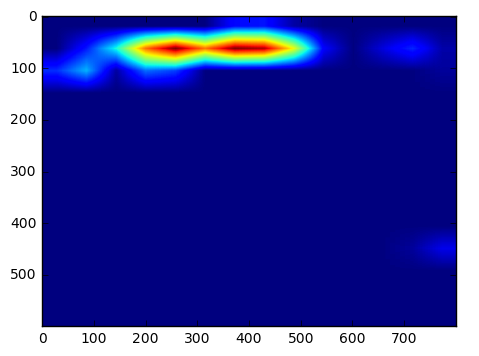

In [18]:
####activation map, which has highest nss score in annotated region 1 
plt.imshow(imresize(n_act_map[np.argmax(sta[0]),:,:],[s[1],s[0]]))

/Users/apple/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


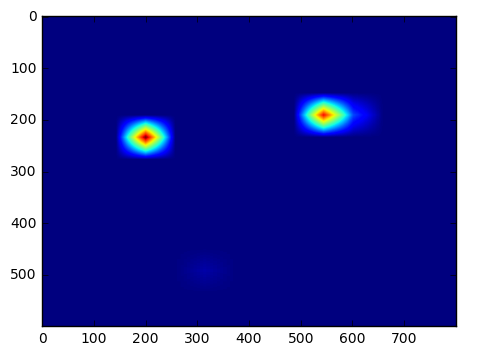

In [19]:
####activation map, which has highest nss score in annotated region 2 
plt.imshow(imresize(n_act_map[np.argmax(sta[1]),:,:],[s[1],s[0]]))

/Users/apple/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


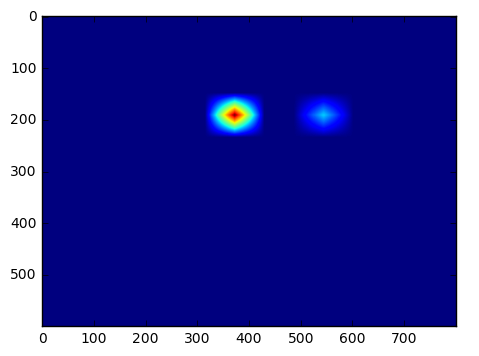

In [20]:
####activation map, which has highest nss score in annotated region 3 
plt.imshow(imresize(n_act_map[np.argmax(sta[2]),:,:],[s[1],s[0]]))

/Users/apple/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


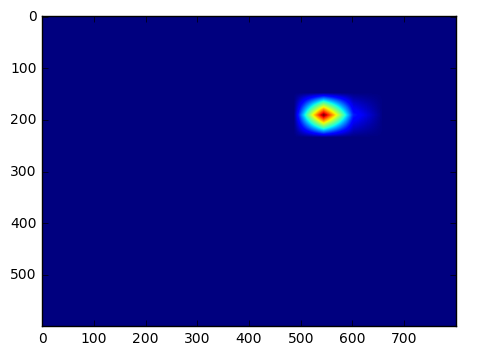

In [21]:
####activation map, which has highest nss score in annotated region 4 
plt.imshow(imresize(n_act_map[np.argmax(sta[3]),:,:],[s[1],s[0]]))

/Users/apple/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


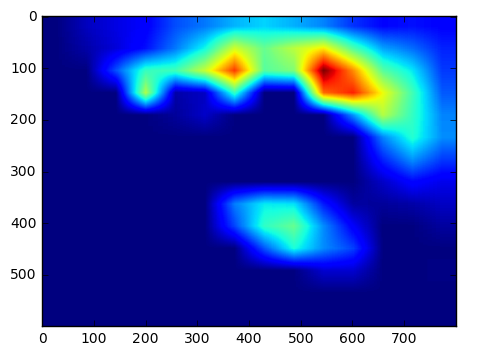

In [22]:
####activation map, which has highest nss score in annotated region 5 
plt.imshow(imresize(n_act_map[np.argmax(sta[4]),:,:],[s[1],s[0]]))